# pset 08: the adventure of the chimeric reads


In [1]:
#importing allowed modules
import numpy as np
import matplotlib.pyplot as plt     
import scipy.stats as stats        
import scipy.special as special    
import seaborn as sns              
import pandas as pd               

%matplotlib inline

In [2]:
# downloading the data
!curl -O http://www.mcb112.org/w08/moriarty-reads.fa
!curl -O http://www.mcb112.org/w08/moriarty-reads.truth

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4230  100  4230    0     0   102k      0 --:--:-- --:--:-- --:--:--  121k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   381  100   381    0     0  10873      0 --:--:-- --:--:-- --:--:-- 15240


As a first step, I imported Moriarty's sequences and the ground truth files, and used separate functions to parse them for convenient data access later in the assignment. 

The `parse_fasta` function reads the sequences from Moriarty's FASTA file and stores them in a dictionary with headers as keys. Meanwhile, the `parse_ground_truth` function reads the ground truth file and creates a dictionary with each read’s metadata and expected state path.

In [3]:
def parse_fasta(filename):
    """parses a fasta file and returns a dictionary of sequences with headers as keys"""
    sequences = {}
    with open(filename, 'r') as file:
        current_read = None
        sequence = []
        for line in file:
            line = line.strip()
            if line.startswith('>'):  # detects new read header
                if current_read:
                    sequences[current_read] = ''.join(sequence)  # stores completed sequence
                current_read = line[1:]  # sets current read name without '>'
                sequence = []
            else:
                sequence.append(line)  # adds sequence line to current sequence
        if current_read:
            sequences[current_read] = ''.join(sequence)  # stores last sequence

    return sequences

In [4]:
def parse_ground_truth(filename):
    """parses a ground truth file and returns a dictionary with read metadata and state paths"""
    ground_truth = {}
    with open(filename, 'r') as file:
        for line in file:
            if line.startswith("#"):
                continue
            readname, L, k, g0, g1 = line.strip().split()
            L, k = int(L), int(k)
            ground_truth[readname] = {
                'length': L,
                'breakpoint': k,
                'state_path': [int(g0)] * (k - 1) + [int(g1)] * (L - k + 1)
            }
    return ground_truth

In [5]:
# Parse sequences and ground truth
MORsequences = parse_fasta("moriarty-reads.fa")
ground_truth = parse_ground_truth("moriarty-reads.truth")

## task 1 - implementing the standard HMM algorithms

To implement standard HMM algorithms for analyzing Moriarty's chimeric reads, I developed functions to compute Viterbi, Forward, and Backward matrices, as well as functions for posterior decoding, posterior path inference, and inferred path (Viterbi/posterior) comparison with the ground truth.

To build the functions, I relied mostly on the pseudocode provided in the lecture notes, with small alterations to get the code to work for my purposes. 

**HMM setup and initialization**

- **`make_hmm`**: Sets up the HMM for chimeric reads, initializing the transition matrix `t` and emission matrix `e` based on known GC content for AluminumJesus and T4, and the expected segment length. This is essentially the same code provided in the pset, with the addition of Laplace smoothing applied via `laplace_smooth` to avoid zero probabilities **that occurred downstream in my Forward and Backward functions**, ensuring stability during computations.

**Algorithms**

- **`viterbi`**: Finds the most probable state path through the sequence using the Viterbi algorithm. The function initializes log probabilities for each state, builds the dynamic programming matrix by iterating through each position in the sequence, and backtracks to extract the best state path.

- **`forward`**: Calculates the Forward matrix and total log probability of the sequence, allowing evaluation of the likelihood of observed residues given the HMM. This function initializes log probabilities for the starting observation, iterates through the sequence using a recursive formula, and finally computes the log probability of the entire sequence.

- **`backward`**: Computes the Backward matrix and total log probability of the sequence, similar to `forward`. This method iterates backward through the sequence, calculating probabilities of future observations given each state.

**Posterior decoding and path inference**

- **`posterior_decoding`**: Combines the Forward and Backward matrices to calculate posterior probabilities for each state at each position in the sequence.
  
- **`posterior_path`**: Infers the best path based on posterior probabilities, using a threshold to filter low-confidence state assignments as unknown. Bases with probabilities below the threshold are marked as `None` for easy filtering downstream, providing a refined state path with only high-confidence assignments.

- **`compare_paths`**: Compares the inferred state path to the ground truth by calculating the accuracy of state assignments. This function excludes "unknown" (`None`) calls, focusing on confident predictions and providing an accuracy score for model evaluation.

In [6]:
def laplace_smooth(matrix, epsilon=1e-10):
    """applies laplace smoothing to a matrix to avoid zero probabilities"""
    smoothed_matrix = matrix + epsilon
    smoothed_matrix /= smoothed_matrix.sum(axis=1, keepdims=True)
    return smoothed_matrix

def make_hmm():
    """creates an HMM transition and emission matrix for a chimeric phage read model"""
    p = 1 / 200  # mean segment length of 100

    # initializes the transition matrix (3x3)
    t = np.array([
        [0.0, 0.5, 0.5],       # state 0 = start/end
        [p, 1 - 2 * p, p],     # state 1 = AluminumJesus
        [p, p, 1 - 2 * p]      # state 2 = T4
    ])
    t = laplace_smooth(t)  # applies laplace smoothing to transition matrix

    # initializes the emission matrix (3x4) for bases A, C, G, T
    e = np.array([
        [0.25, 0.25, 0.25, 0.25],       # state 0, does not emit
        [0.166, 0.334, 0.334, 0.166],   # AluminumJesus composition
        [0.323, 0.177, 0.177, 0.323]    # T4 composition
    ])
    return t, e

In [7]:
def viterbi(sequence, t, e):
    """computes the most probable state path for a given sequence using the viterbi algorithm"""
    n_states = t.shape[0]
    L = len(sequence)
    
    # initializes log probabilities and path pointers
    log_probs = np.full((L, n_states), -np.inf)  # log probabilities initialized to -inf
    path_pointers = np.zeros((L, n_states), dtype=int)

    # initialization: starting probabilities for each state from the start state (0)
    for s in range(1, n_states):
        log_probs[0, s] = np.log(t[0, s]) + np.log(e[s, sequence[0]])

    # fills dp table
    for i in range(1, L):
        for s in range(1, n_states):
            # computes max probability over all possible previous states
            max_prob = -np.inf
            max_state = 0
            for s_prev in range(1, n_states):
                prob = log_probs[i - 1, s_prev] + np.log(t[s_prev, s])
                if prob > max_prob:
                    max_prob = prob
                    max_state = s_prev
            log_probs[i, s] = max_prob + np.log(e[s, sequence[i]])
            path_pointers[i, s] = max_state

    # termination: finds the best final state and probability
    best_last_state = np.argmax(log_probs[L - 1, 1:]) + 1  # best ending state
    max_log_prob = log_probs[L - 1, best_last_state]  # corresponding log probability

    # backtrack to get the best path
    best_path = np.zeros(L, dtype=int)
    best_path[L - 1] = best_last_state
    for i in range(L - 2, -1, -1):
        best_path[i] = path_pointers[i + 1, best_path[i + 1]]

    return best_path, max_log_prob

In [8]:
def forward(sequence, t, e):
    """calculates the forward matrix and the total log probability of the sequence"""
    n_states = t.shape[0]
    L = len(sequence)
    
    # initializes the forward matrix in log space
    forward_probs = np.full((n_states, L), -np.inf)

    # base case: sets starting probabilities for the first observation
    for s in range(1, n_states):
        forward_probs[s, 0] = np.log(t[0, s]) + np.log(e[s, sequence[0]])

    # recursion: fills in the forward matrix for each position in the sequence
    for i in range(1, L):
        for s in range(1, n_states):
            forward_probs[s, i] = np.log(e[s, sequence[i]]) + special.logsumexp([
                forward_probs[s_prev, i - 1] + np.log(t[s_prev, s]) for s_prev in range(1, n_states)
            ])

    # termination: calculates the total log probability of the observed sequence
    log_prob_x = special.logsumexp([
        forward_probs[s, L - 1] + np.log(t[s, 0]) for s in range(1, n_states)
    ])
    
    return log_prob_x, forward_probs

def backward(sequence, t, e):
    """calculates the backward matrix and the total log probability of the sequence"""
    n_states = t.shape[0]
    L = len(sequence)
    
    # initializes the backward matrix with -inf for log space
    backward_probs = np.full((n_states, L), -np.inf)

    # initialization: sets end probabilities
    for s in range(1, n_states):
        backward_probs[s, L - 1] = np.log(t[s, 0])

    # fills backward matrix
    for i in range(L - 2, -1, -1):
        for s in range(1, n_states):
            backward_probs[s, i] = special.logsumexp([
                backward_probs[s_next, i + 1] + np.log(t[s, s_next]) + np.log(e[s_next, sequence[i + 1]])
                for s_next in range(1, n_states)
            ])

    # termination: sums over transitions to the start state
    log_prob_x = special.logsumexp([
        np.log(t[0, s]) + np.log(e[s, sequence[0]]) + backward_probs[s, 0]
        for s in range(1, n_states)
    ])
    
    return log_prob_x, backward_probs

Before moving to path inference and posterior decoding, I wanted to ensure my Forward and Backward algorithms provided the same total log probabilities as a "sanity check". This alignment confirms that both algorithms are correctly implemented, as the total log probability of observing the sequence should match between the two methods:

In [9]:
def encode_base(base):
    """encodes a nucleotide base as an integer for HMM compatibility"""
    encoding = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    return encoding[base]

In [10]:
t, e = make_hmm()
example_read = MORsequences['read0']
encoded_sequence = [encode_base(base) for base in example_read]
forward_log, forward_probs = forward(encoded_sequence, t, e)
backward_log, backward_probs = backward(encoded_sequence, t, e)
print (f' total log probability using *forward* algorithm: {round(forward_log,4)}, \n total log probability using *backward* algorithm: {round(backward_log,4)}.')

 total log probability using *forward* algorithm: -269.2333, 
 total log probability using *backward* algorithm: -269.2333.


In [11]:
def posterior_decoding(forward_probs, backward_probs):
    """calculates posterior probabilities for each state and position using forward and backward matrices"""
    n_states, L = forward_probs.shape
    posterior_probs = np.zeros((n_states, L))

    for i in range(L):
        # computes normalization factor, summing over valid states
        total = special.logsumexp([forward_probs[s, i] + backward_probs[s, i] for s in range(1, n_states)])
        
        # calculates posterior probability for each state
        for s in range(1, n_states):
            posterior_probs[s, i] = np.exp(forward_probs[s, i] + backward_probs[s, i] - total)

    return posterior_probs

In [12]:
def infer_posterior_path(posterior_probs, threshold=0.9):
    """infers the most probable state path based on posterior probabilities.
    takes a threshold probability below which the state in a current position is unknown."""
    path = []
    for i in range(posterior_probs.shape[1]):
        max_state = np.argmax(posterior_probs[1:, i]) + 1  # ignores state 0
        max_prob = posterior_probs[max_state, i]
        if max_prob >= threshold:
            path.append(max_state)
        else:
            path.append(None)  # marks as None for "unknown" if below threshold
    return path

In [13]:
def compare_paths(ground_truth, inferred_path):
    """compares ground truth and inferred state paths, calculating accuracy"""
    correct = 0
    total = 0

    for gt, inf in zip(ground_truth, inferred_path):
        if inf is not None:  # ignores unknown assignments
            total += 1
            if gt == inf:
                correct += 1

    accuracy = correct / total if total > 0 else 0
    return accuracy

## task 2 - testing synthetic positive controls

To evaluate the accuracy of my HMM algorithms (`Viterbi` and `Posterior decoding`), I wrote functions to perform and plot a synthetic control experiment. I used `synthetic_control_experiment` to generate a set of variable-length synthetic sequences (with \( n = 100 \)), based on the transition and emission matrices, then calculated accuracies for each approach (`Viterbi` and `Posterior decoding`) for each sequence. I used a maximum sequence length of 300bp, which is close to Moriarty's read length but extends slightly longer to explore the effect of sequence length.

**Synthetic Sequence Generation**: I generated 100 synthetic sequences with variable lengths using `generate_synthetic_sequence`, allowing segments to terminate naturally based on self-loop probabilities in the HMM. Each sequence comes with a known state path, which serves as ground truth.

**Analysis and Accuracy Calculation**: For each synthetic sequence, I computed both the Viterbi path and the decoded path using posterior probabilities. I then calculated accuracy scores for each path against the known ground truth using `compare_paths`. Each result was stored with its sequence length, Viterbi accuracy, and Posterior accuracy.

**Plotting the Results**: Using `plot_synthetic_control_experiment`, I plotted accuracy scores as a function of sequence length, comparing the performance of the Viterbi and Posterior decoding methods. The plot includes lines for both accuracy types, along with horizontal lines marking the mean accuracy for each method.

In [14]:
def generate_synthetic_sequence(t, e, max_length=300):
    """generates a synthetic sequence and state path using HMM transition and emission matrices"""
    sequence = []
    state_path = []
    current_state = 0  # start state

    while len(sequence) < max_length:
        # transitions to the next state using probability distribution from current_state
        next_state = np.random.choice(len(t), p=t[current_state])
        if next_state == 0:  # checks if end state is reached
            break
        
        # emits a base according to emission probabilities for the chosen state
        emitted_base = np.random.choice(len(e[next_state]), p=e[next_state])
        
        # appends emitted base to sequence and records state path
        sequence.append(emitted_base)
        state_path.append(next_state)
        
        # updates current state to next state
        current_state = next_state

    return sequence, state_path

In [15]:
def analyze_synthetic_sequence(sequence, true_path, t, e):
    """analyzes a synthetic sequence by calculating viterbi and posterior path accuracies"""
    
    # viterbi path and accuracy
    viterbi_path, _ = viterbi(sequence, t, e)
    viterbi_accuracy = compare_paths(true_path, viterbi_path)
    
    # posterior decoding path and accuracy
    _, forward_probs = forward(sequence, t, e)
    _, backward_probs = backward(sequence, t, e)
    posterior_probs = posterior_decoding(forward_probs, backward_probs)
    posterior_path = infer_posterior_path(posterior_probs)
    posterior_accuracy = compare_paths(true_path, posterior_path)
    
    return viterbi_accuracy, posterior_accuracy

In [16]:
def synthetic_control_experiment(t, e, num_sequences=100, max_length=300):
    """generates synthetic sequences and evaluates viterbi and posterior decoding accuracies"""
    results = []
    for _ in range(num_sequences):
        # generates synthetic sequence and true state path
        sequence, true_path = generate_synthetic_sequence(t, e, max_length)
        
        # analyzes sequence with viterbi and posterior decoding
        viterbi_accuracy, posterior_accuracy = analyze_synthetic_sequence(sequence, true_path, t, e)
        
        # stores results for this sequence
        results.append({
            'sequence_length': len(sequence),
            'viterbi_accuracy': viterbi_accuracy,
            'posterior_accuracy': posterior_accuracy
        })

    return results

In [17]:
def plot_synthetic_control_experiment(result_df):
    """plots accuracy of viterbi and posterior decoding as a function of sequence length"""
    
    # sorts data by sequence length to ensure lines connect in order
    df = result_df.sort_values("sequence_length")
    
    # creates the plot
    plt.figure(figsize=(12, 6))
    
    # plots lines for viterbi and posterior accuracies
    plt.plot(df["sequence_length"], df["viterbi_accuracy"], color="blue", label="Viterbi Accuracy", marker='o', linestyle='-', alpha=0.7)
    plt.plot(df["sequence_length"], df["posterior_accuracy"], color="orange", label="Posterior Accuracy", marker='o', linestyle='-', alpha=0.7)
    
    # calculates and plots the mean accuracy as horizontal lines
    viterbi_mean = df["viterbi_accuracy"].mean()
    posterior_mean = df["posterior_accuracy"].mean()
    plt.axhline(viterbi_mean, color="blue", linestyle=":", linewidth=2, label=f"Viterbi Mean ({viterbi_mean:.2f})")
    plt.axhline(posterior_mean, color="orange", linestyle=":", linewidth=2, label=f"Posterior Mean ({posterior_mean:.2f})")
    
    # labels and title
    plt.xlabel("Sequence Length")
    plt.ylabel("Accuracy")
    plt.title("Accuracy of Viterbi and Posterior Decoding vs. Sequence Length")
    plt.legend(loc="lower right")
    plt.ylim(-0.05, 1.05)  # sets y-axis limits to 0-1 for percentage accuracy
    plt.grid(True, linestyle="--", alpha=0.6)
    
    # displays the plot
    plt.show()

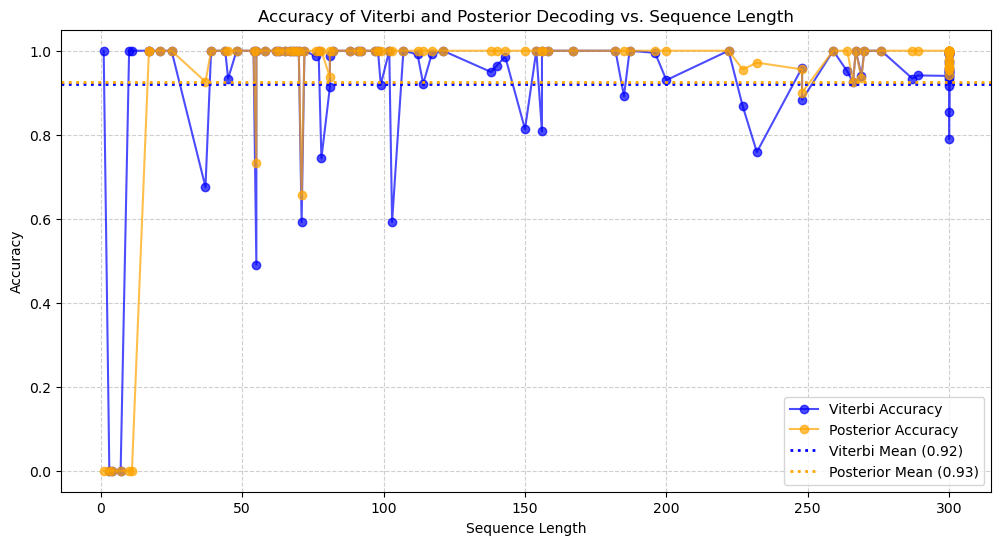

In [18]:
# Define HMM parameters
t, e = make_hmm()

# Run synthetic control experiment
synthetic_results = synthetic_control_experiment(t, e)
synthetic_results_df = pd.DataFrame(synthetic_results)
plot_synthetic_control_experiment(synthetic_results_df)

Running my synthetic control experiment showed a trend of better accuracies as total sequence length increases. Longer sequences provide more data points for the HMM, which improves its ability to make accurate state predictions and reduce errors due to random noise that can affect shorter sequences. **This is especially true for posterior decoding**.

It’s important to note two main differences between the synthetic sequences I generated and Moriarty's real data:

1. **Fixed Sequence Length**: In Moriarty's sequencing data, all sequences are fixed at 200 bp, whereas my synthetic sequences have variable lengths. This difference should improve the overall accuracy of the HMM algorithms when applied to the real data, as the HMM does not perform as well with shorter sequences.

2. **Single Transition Point**: The HMM model and sequence generation function allow for multiple state transitions within a single sequence, while Moriarty’s real data has only one “breakpoint” connecting segments from the two phages. The single breakpoint in Moriarty's reads provides a simpler structure that the HMM could potentially model more accurately.

To explore whether applying these changes would improve accuracy on the synthetic sequences, I wrote a function to generate sequences with only one breakpoint and, optionally, to fix them at a maximal length.

In [19]:
def generate_synthetic_sequence_with_single_breakpoint(t, e, max_length=300, fixed_length=False):
    """generates a synthetic sequence with a single breakpoint and optional fixed length"""
    
    # chooses a random breakpoint
    break_p = np.random.randint(0, max_length)

    sequence = []
    state_path = []

    # randomly selects the starting state (either state 1 or state 2)
    current_state = np.random.choice([1, 2])
    other_state = 1 if current_state == 2 else 2  # state to switch to at the breakpoint

    # generates the first segment up to the breakpoint
    while len(sequence) < break_p:
        emitted_base = np.random.choice(len(e[current_state]), p=e[current_state])  # emits base for current state
        sequence.append(emitted_base)
        state_path.append(current_state)

    # switches to the other state at the breakpoint
    current_state = other_state

    # determines the length of the second segment based on max_length and fixed_length option
    second_segment_length = max_length - break_p if fixed_length else np.random.randint(0, max_length - break_p + 1)

    # generates the second segment up to the chosen length
    for _ in range(second_segment_length):
        emitted_base = np.random.choice(len(e[current_state]), p=e[current_state])
        sequence.append(emitted_base)
        state_path.append(current_state)

    return sequence, state_path

def synthetic_control_experiment_with_single_breakpoint(t, e, num_sequences=100, max_length=300, fixed_length=False):
    """generates synthetic sequences with single breakpoints and evaluates viterbi and posterior accuracies"""
    
    results = []
    for _ in range(num_sequences):
        # generates synthetic sequence and true state path
        sequence, true_path = generate_synthetic_sequence_with_single_breakpoint(t, e, max_length=max_length, fixed_length=fixed_length)
        
        # analyzes sequence with viterbi and posterior decoding
        viterbi_accuracy, posterior_accuracy = analyze_synthetic_sequence(sequence, true_path, t, e)
        
        # stores results for this sequence
        results.append({
            'sequence_length': len(sequence),
            'viterbi_accuracy': viterbi_accuracy,
            'posterior_accuracy': posterior_accuracy
        })

    return results

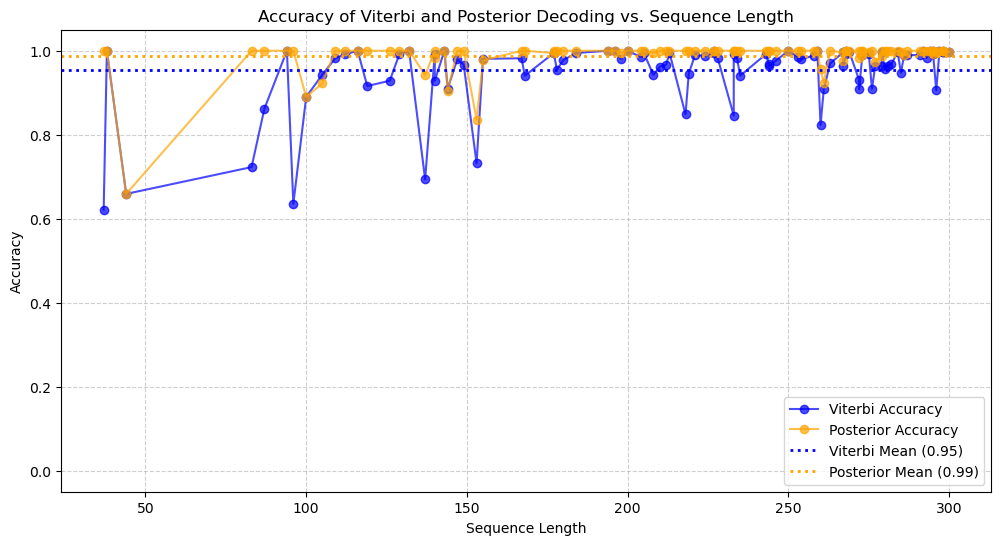

In [21]:
# Define HMM parameters
t, e = make_hmm()

# Run synthetic control experiment
synthetic_results = synthetic_control_experiment_with_single_breakpoint(t, e)
synthetic_results_df = pd.DataFrame(synthetic_results)
plot_synthetic_control_experiment(synthetic_results_df)

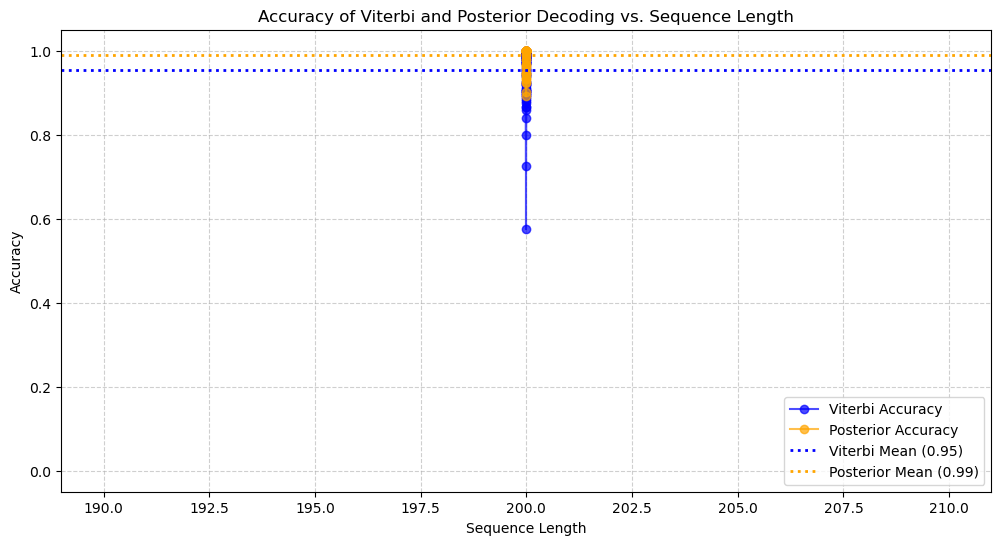

In [23]:
# Define HMM parameters
t, e = make_hmm()

# Run synthetic control experiment
synthetic_results = synthetic_control_experiment_with_single_breakpoint(t, e, max_length=200, fixed_length=True)
synthetic_results_df = pd.DataFrame(synthetic_results)
plot_synthetic_control_experiment(synthetic_results_df)

Using this new approach to generate synthetic sequences with a single breakpoint, I observed improved accuracies across sequence lengths (when the lengths were not fixed). The improvement was more pronounced in the posterior decoding approach than in the Viterbi approach. 

When I fixed the sequence length at 200 bp and enforced a single breakpoint, both methods achieved their highest accuracies. This setup closely matches the real structure of Moriarty's data. In the next task, I tested how the HMM functions actually perform on Moriarty's data.

## task 3 - analyzing Moriarty's read sequences

To analyze Moriarty's reads, I adapted the functions used to analyze the synthetic reads. The `analyze_reads` function calculates the state paths from both the Viterbi algorithm and the posterior decoding approach. Then, `compare_to_ground_truth` uses Wiggins' ground truth file to compare each inferred path to the true state path and return the accuracy.

In [24]:
def analyze_reads(sequences, ground_truth, hmm_t, hmm_e):
    """analyzes reads by computing viterbi and posterior paths for each sequence"""
    
    viterbi_results = {}
    posterior_results = {}

    for readname, sequence in sequences.items():
        # encodes sequence into integers (e.g., A=0, C=1, G=2, T=3)
        encoded_sequence = [encode_base(base) for base in sequence]

        # runs viterbi algorithm
        viterbi_path, _ = viterbi(encoded_sequence, hmm_t, hmm_e)
        viterbi_results[readname] = viterbi_path

        # runs forward and backward algorithms to obtain posterior decoding
        _, forward_probs = forward(encoded_sequence, hmm_t, hmm_e)
        _, backward_probs = backward(encoded_sequence, hmm_t, hmm_e)
        posterior_probs = posterior_decoding(forward_probs, backward_probs)
        posterior_path = infer_posterior_path(posterior_probs)
        posterior_results[readname] = posterior_path

    return viterbi_results, posterior_results

In [25]:
def compare_to_ground_truth(ground_truth, viterbi_results, posterior_results):
    """compares inferred viterbi and posterior paths to ground truth and calculates average accuracy"""
    
    viterbi_accuracy = []
    posterior_accuracy = []

    for readname, truth in ground_truth.items():
        true_path = truth['state_path']
        
        # calculates Viterbi accuracy
        viterbi_path = viterbi_results[readname]
        viterbi_acc = compare_paths(true_path, viterbi_path)
        viterbi_accuracy.append(viterbi_acc)
        
        # calculates Posterior Decoding accuracy
        posterior_path = posterior_results[readname]
        posterior_acc = compare_paths(true_path, posterior_path)
        posterior_accuracy.append(posterior_acc)

    # calculates average accuracy for Viterbi and Posterior decoding
    avg_viterbi_accuracy = sum(viterbi_accuracy) / len(viterbi_accuracy)
    avg_posterior_accuracy = sum(posterior_accuracy) / len(posterior_accuracy)

    return avg_viterbi_accuracy, avg_posterior_accuracy

In [26]:
# load HMM parameters
t, e = make_hmm()

# parse sequences and ground truth
sequences = parse_fasta("moriarty-reads.fa")
ground_truth = parse_ground_truth("moriarty-reads.truth")

# analyze reads using Viterbi and posterior decoding
viterbi_results, posterior_results = analyze_reads(sequences, ground_truth, t, e)

# compare inferred paths to ground truth and calculate average accuracy
avg_viterbi_accuracy, avg_posterior_accuracy = compare_to_ground_truth(ground_truth, viterbi_results, posterior_results)

# display average accuracies for Viterbi and Posterior decoding
print(f"Viterbi average accuracy: {round(avg_viterbi_accuracy,4)}")
print(f"Posterior decoding average accuracy: {round(avg_posterior_accuracy,4)}")

Viterbi average accuracy: 0.975
Posterior decoding average accuracy: 0.9932


### main conclusion

In terms of accuracy score, the HMM performs well in inferring the structure of each chimeric read, and seems to effectively distinguish which residues came from each source genome. For Moriarty's reads, the Viterbi algorithm achieved an average accuracy of 97.5%, while posterior decoding reached 99.3%. These results indicate that both methods can reliably identify the source genome for each segment, though posterior decoding is slightly more accurate.

In comparison to my synthetic sequences, which yielded average accuracies of around 95% for Viterbi and around 99% for posterior decoding when I made them as similar as possible to the real data, the results on Moriarty’s data are consistent. Posterior decoding tends to perform better, likely due to its ability to factor in uncertainties across all possible paths rather than relying solely on the single most probable path, as Viterbi does. This increased sensitivity in posterior decoding provides a clearer distinction between states, contributing to its higher accuracy. It is important to note, however, that the accuracy calculation does not include the segments where the posterior decoding algorithm determines a position to be of unknown state (as per the pset instructions).

Below is a visualization showing which residues came from each source genome in each of Moriarty's reads, alongside the performance of the Viterbi and Posterior decoding models:

In [27]:
def plot_read_analysis(readname, sequence, true_path, viterbi_path, posterior_path):
    """plots true origins vs. viterbi and posterior decoding predictions for a chimeric read"""
    L = len(sequence)
    
    # calculates accuracy for Viterbi and Posterior decoding
    viterbi_accuracy = compare_paths(true_path, viterbi_path)
    posterior_accuracy = compare_paths(true_path, posterior_path)
    
    # sets color mapping: AluminumJesus as light blue, T4 as light red
    true_colors = ['purple' if state == 1 else 'goldenrod' for state in true_path]
    viterbi_colors = [
        'seagreen' if viterbi == true else "orangered" if viterbi is not None else 'lightgray'
        for viterbi, true in zip(viterbi_path, true_path)
    ]
    posterior_colors = [
        'seagreen' if post == true else "orangered" if post is not None else 'lightgray'
        for post, true in zip(posterior_path, true_path)
    ]
    
    # creates figure with compact vertical size
    fig, ax = plt.subplots(figsize=(16, 1.2))
    ax.set_xlim(0, L)
    ax.set_ylim(-0.5, 1.5)

    # plots true origin with background colors at y=0
    for i in range(L):
        ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=true_colors[i]))
    
    # plots Viterbi path predictions above the true path at y=1
    for i in range(L):
        ax.add_patch(plt.Rectangle((i, 1), 1, 0.5, color=viterbi_colors[i]))
        
    # plots Posterior path predictions below the true path at y=-0.5
    for i in range(L):
        ax.add_patch(plt.Rectangle((i, -0.5), 1, 0.5, color=posterior_colors[i]))
    
    # sets title with adjusted padding
    ax.set_title(f"Read: {readname} - True Origin vs. Viterbi and Posterior Decoding Predictions", pad=10)
    ax.set_xlabel("Base Position")
    ax.set_yticks([0.5, 1.25, -0.25])
    ax.set_yticklabels(['True Origin', 'Viterbi Prediction', 'Posterior Prediction'])
    
    # adds legend explanation with adjusted positioning
    ax.text(L + 5, 1.25, "Viterbi Correct", color="seagreen", ha="left", va="center")
    ax.text(L + 5, 1, "Viterbi Incorrect", color="orangered", ha="left", va="center")
    ax.text(L + 5, 0.5, "True: AluminumJesus", color="purple", ha="left", va="center")
    ax.text(L + 5, 0.25, "True: T4", color="goldenrod", ha="left", va="center")
    ax.text(L + 5, -0.25, "Posterior Correct", color="seagreen", ha="left", va="center")
    ax.text(L + 5, -0.5, "Posterior Incorrect", color="orangered", ha="left", va="center")
    ax.text(L + 5, -1, "Unknown/Uninferred", color="gray", ha="left", va="center")

    # displays accuracy for each model with fine-tuned vertical positioning
    ax.text(15, 1.75, f"Viterbi Accuracy: {viterbi_accuracy:.2%}", ha="center", va="center", color="green")
    ax.text(15, -1.2, f"Posterior Accuracy: {posterior_accuracy:.2%}", ha="center", va="center", color="green")

    plt.show()

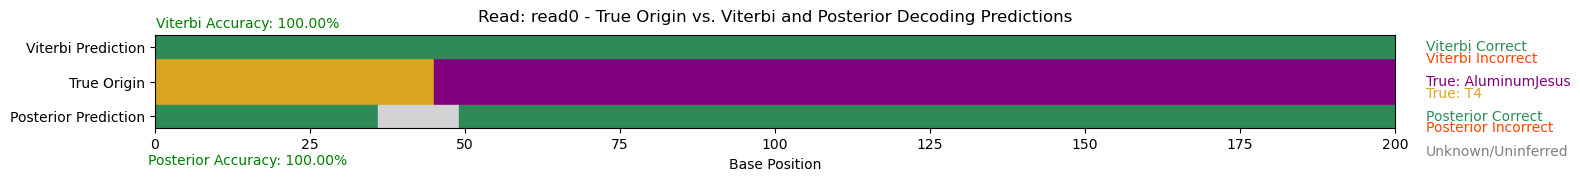

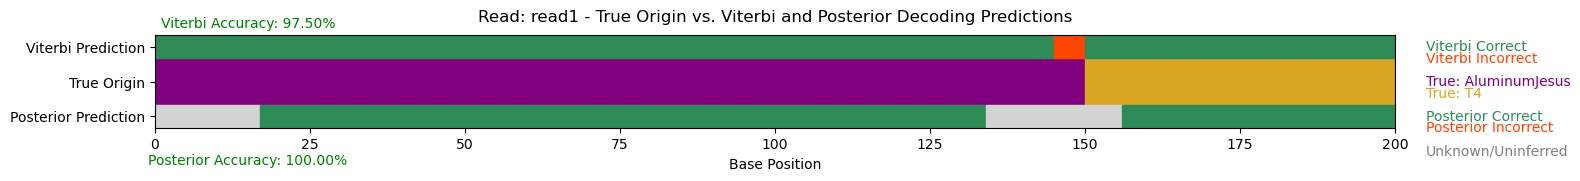

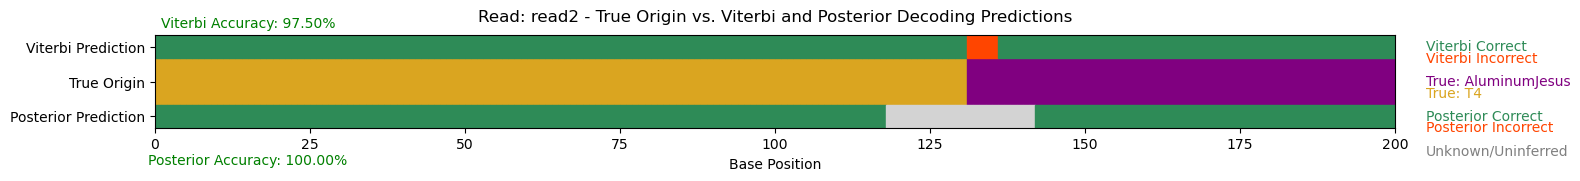

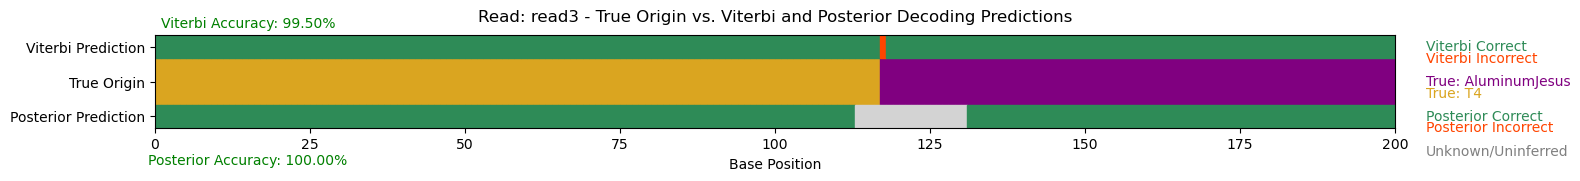

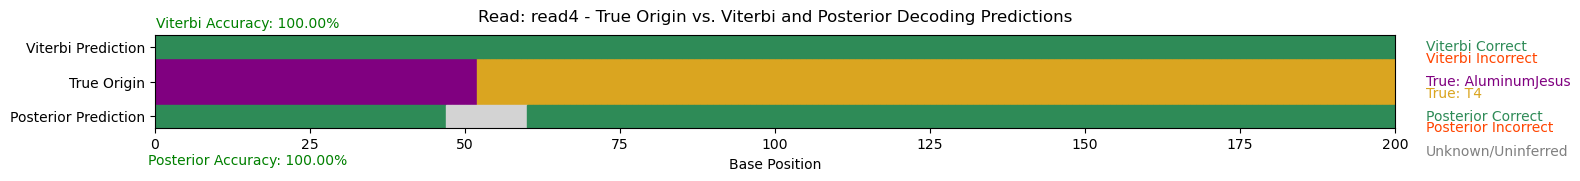

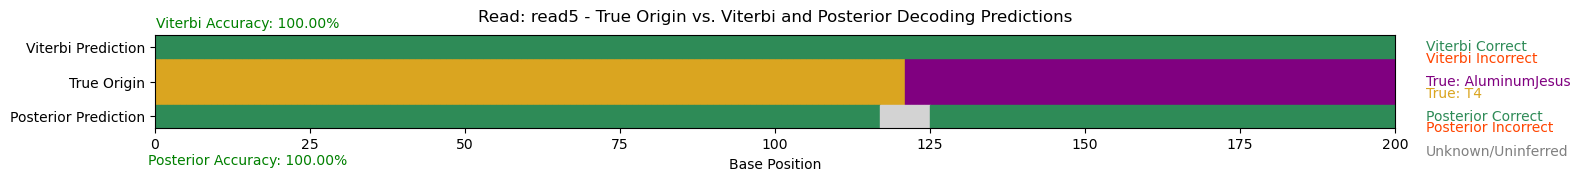

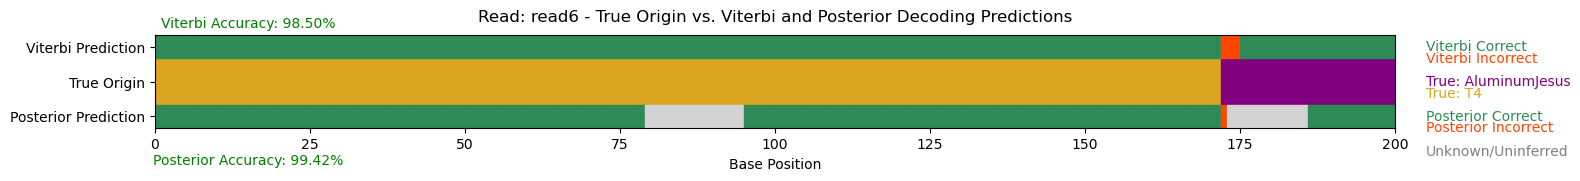

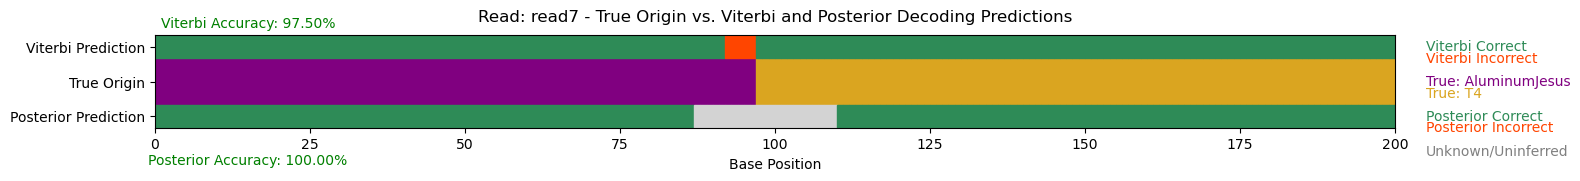

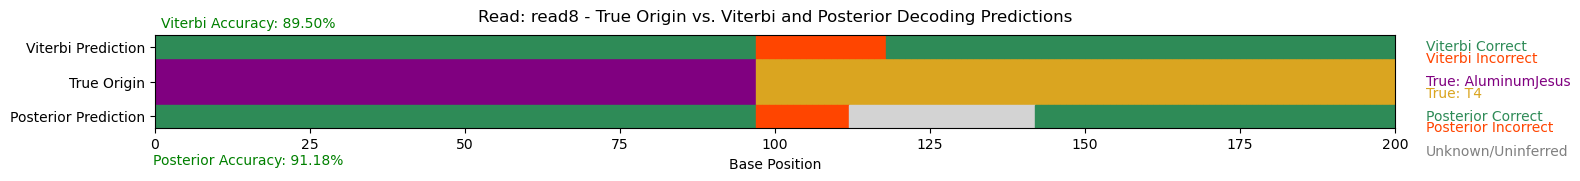

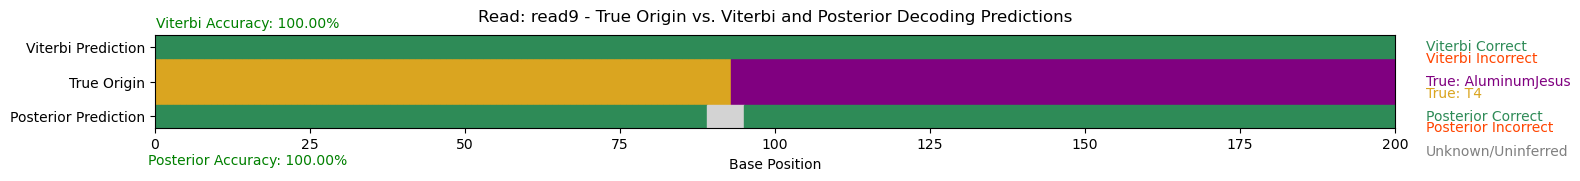

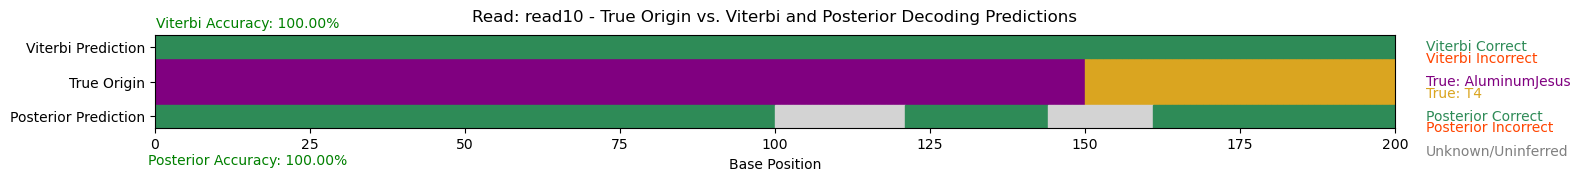

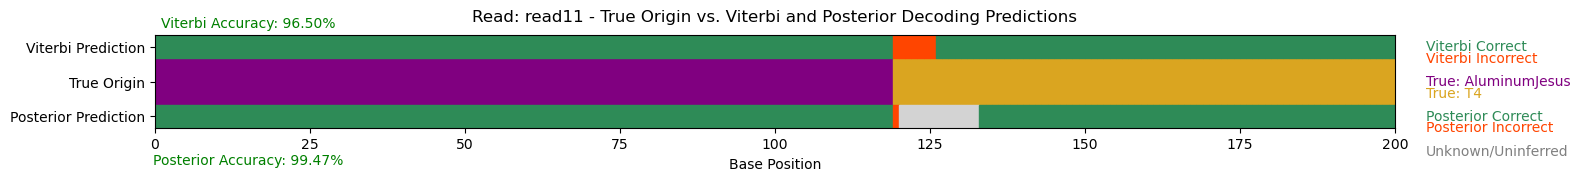

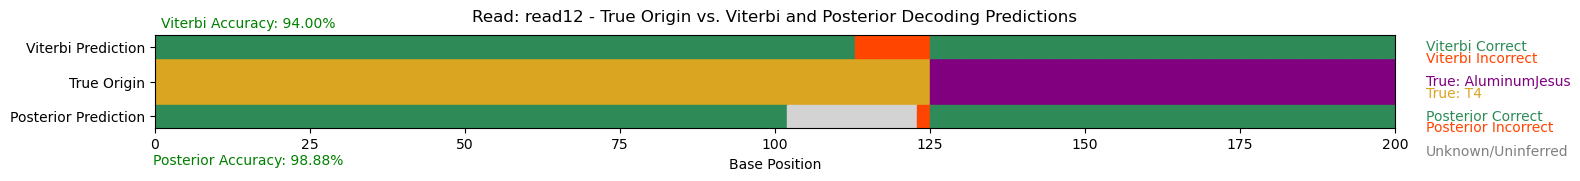

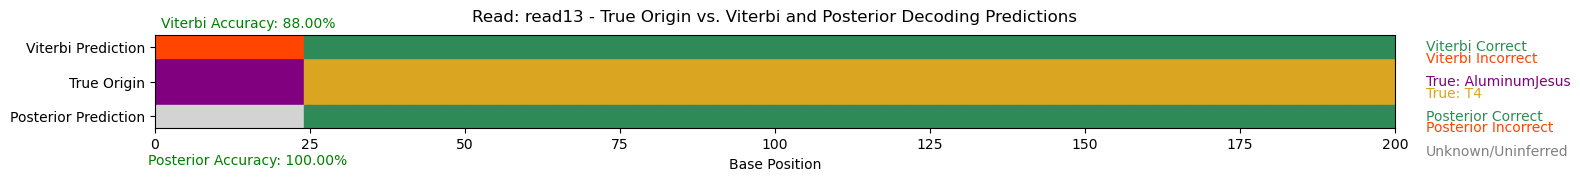

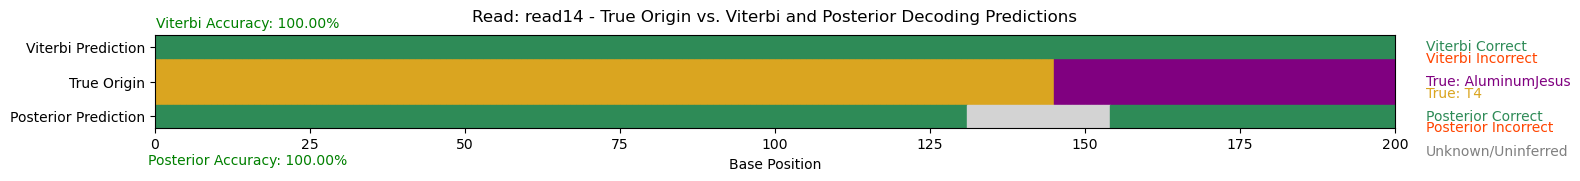

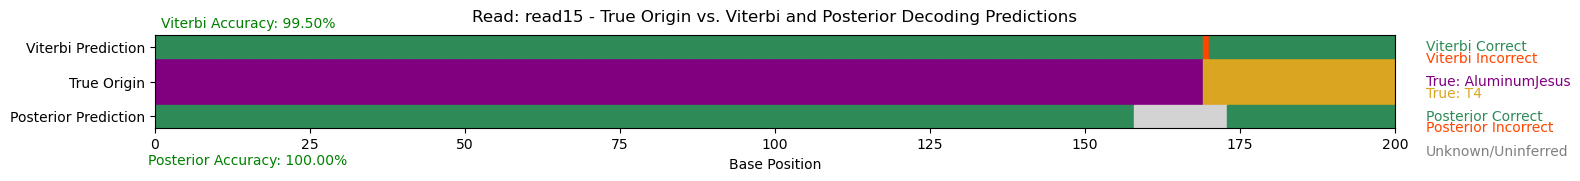

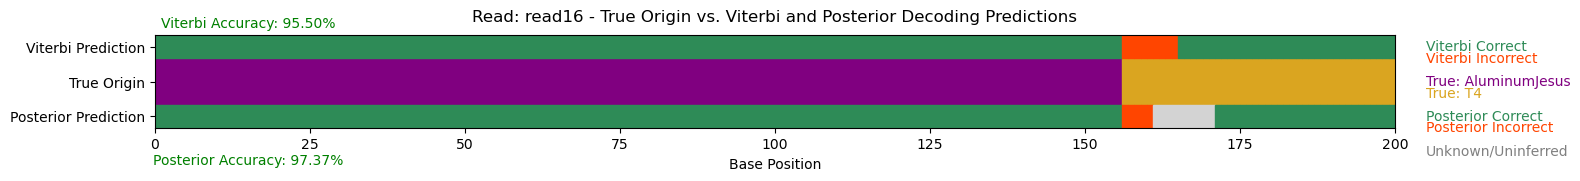

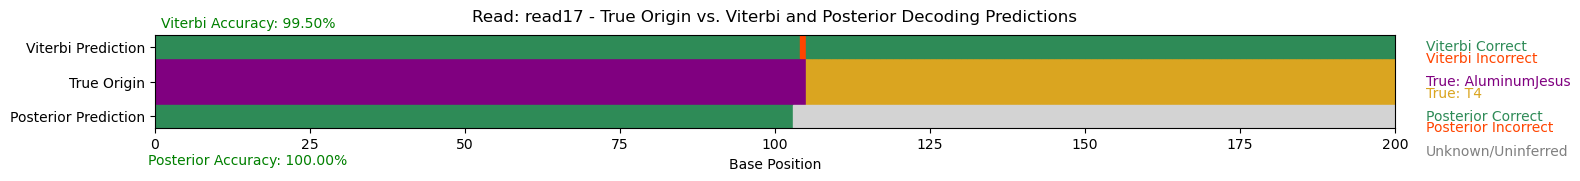

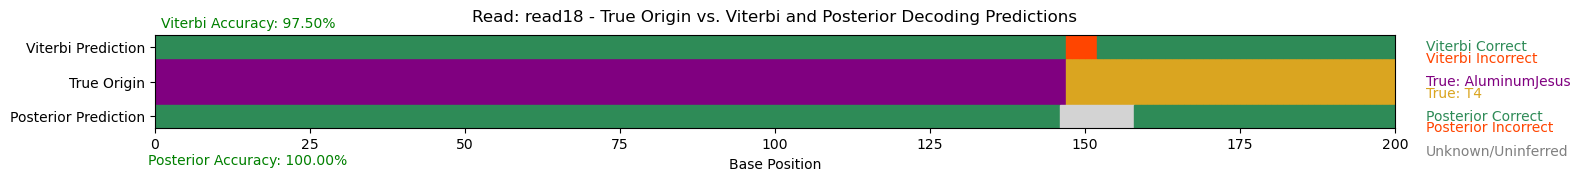

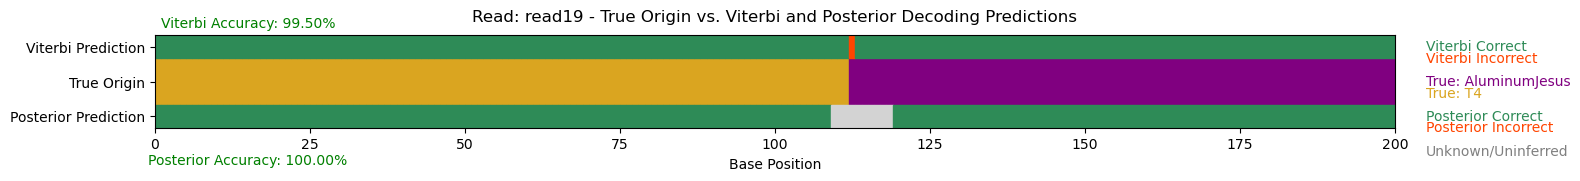

In [28]:
for i in range(20):
    readname = f'read{i}' # Name of the read
    sequence = MORsequences[readname]  # The actual DNA sequence of the read
    true_path = ground_truth[readname]['state_path']  # True origin path
    viterbi_path = viterbi_results[readname]  # Viterbi inferred path
    posterior_path = posterior_results[readname]  # Posterior inferred path
    
    plot_read_analysis(readname, sequence, true_path, viterbi_path, posterior_path)

## task 4 - suggesting a better HMM, and a better approach altogether

### HMM architecture for Moriarty’s data and the generation of synthetic sequences

In Task 2, I generated synthetic sequences that better match the observed structure of Moriarty’s reads by adjusting the sequence generation function rather than altering the HMM itself. However, a refined HMM architecture could also be implemented to better capture the fixed-length, single-breakpoint structure of Moriarty’s reads.

**Main change to implement:**
To improve the HMM’s accuracy, the primary modification would be **enforcing a single breakpoint**: each read should have exactly one breakpoint \( k \), where it transitions from one genome (e.g., AluminumJesus) to the other (T4).

**Current HMM architecture:**
The current HMM includes the following three states:

1. *State 0 (Start/End)*: This state transitions equally to State 1 (AluminumJesus) and State 2 (T4), allowing the sequence to start in either state.
2. *State 1 (AluminumJesus)*: Has a self-transition probability of \( 1 - 2p \), allowing the sequence to remain in State 1. There is a probability \( p \) of transitioning to State 2 (T4) and another probability \( p \) of returning to State 0.
3. *State 2 (T4)*: Similarly, State 2 has a self-transition probability of \( 1 - 2p \), with a probability \( p \) of **transitioning back to State 1** and a probability \( p \) of transitioning to State 0.

**Suggested HMM modifications:**
To create a more accurate HMM for Moriarty’s data:
- **Maintain State 0** as a starting/ending non-emitting state, allowing transitions to either State 1 or State 2.
- **Eliminate transitions that allow a return to a previous state after a single transition between States 1 and 2 or termination before 1-2/2-1 transition**.This adjustment should enforce a single breakpoint without permitting multiple state transitions within the sequence.

Trying to implement this adjustment in a transition matrix was a bit challenging for me, as I could not find an effective way to design a transition matrix that would permit a start in any state while enforcing a single, one-way transition.

**My prototype for an improved HMM architecture for Moriarty’s data:**
A conceptual improvement could involve a 3-state HMM with a single enforced transition between the two main states:

- **State 0 (Start/End)**: tarting/ending non-emitting state, allowing transitions to either State 1 or State 2 (same as before).
- **State 1 (AluminumJesus)**: Generates the first segment with AluminumJesus’s nucleotide composition. It would have a high self-transition probability of 1-p, maintaining segment length, and a small probability of transitioning to State 2 at a breakpoint (p).
- **State 2 (T4)**: Represents the second segment with T4’s nucleotide composition. It would also have a high self-transition probability (1-p) and a small probability of transitioning to State 0 to conclude the sequence (p).

the problem with this model is that it generates only full sequences from T4 or a start from AluminumJesus with a single transition to T4 (no T4 to AluminumJesus transition).

**Additional improvements could be: controlled breakpoint position:**
For even greater realism, the model could place the breakpoint around the midpoint, approximating Moriarty’s data structure more closely.

I believe that enforcing a single breakpoint, along with restricting sequence length to a fixed value, can be more easily achieved by adjusting the function that generates synthetic sequences rather than modifying the HMM transition matrix directly. 

### Non-HMM Probability Model for Moriarty’s Data

A simpler approach could be to model Moriarty’s reads as two independent segments, each with its length and nucleotide composition based on known parameters:

1. **Select a Breakpoint \( k \)**: Sample \( k \) from a uniform distribution across possible positions (e.g., between 1 and \( L-1 \)).
2. **Generate Each Segment Independently**:
   - **First Segment (1 to \( k \))**: Generate this segment using the nucleotide composition of AluminumJesus or T4.
   - **Second Segment (\( k+1 \) to \( L \))**: Generate this segment using the other phage’s nucleotide composition.

This model is similar to motif-finding tasks, where we assumed a fixed background with a single motif. Here, the first segment acts as the “background,” transitioning once to a distinct “motif” (the second segment) at the breakpoint \( k \). I could imagine using an E-M algorithm to estimate the most likely transition point \( k \) based on sequence data. This approach would offer a straightforward, probabilistic model to analyze Moriarty’s reads.

In [29]:
%load_ext watermark
%watermark -v -m -p jupyter,numpy,matplotlib

Python implementation: CPython
Python version       : 3.12.6
IPython version      : 8.27.0

jupyter   : 1.1.1
numpy     : 2.1.1
matplotlib: 3.9.2

Compiler    : Clang 17.0.6 
OS          : Darwin
Release     : 21.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

